# Library



In [130]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib

import cv2
import skimage as ski

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn as skl
from statistics import mode

from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import gaussian_kde
from scipy import ndimage

import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Main clustering

In [131]:

import os
bool_exist=False
while bool_exist==False:
 path = "/content/gdrive/MyDrive/"
 name_path = input("Enter the path where the project will be created (if the folder is in 'MyDrive' just write the name of the project): ")
 path += name_path + "/"
 bool_exist=os.path.isdir(path)
 if bool_exist==False:
   print("❌ The path does not exist")
 else:
  print("✅ Project :"+path)
  bool_exist=True

path_img_raw=path+"images/raw/"
path_mask_cell=path+"segmentation/segmentation_cells/mask/"
path_clust=path+"clustering/"
path_clust_mfi=path_clust+"MFI/"
path_segmentation_df=path+"segmentation/segmentation_cells/df_ROI/"

if os.path.isdir(path_img_raw)==False:
   print("❌ You have not completed the step of creating PNG images")
elif os.path.isdir(path_mask_cell)==False:
   print("❌ You have not completed the step of cells segmentation")
elif os.path.isdir(path_clust_mfi)==False:
   print("❌ You have not completed the step of calcul of MFI")
else:
 path_main_clust=path_clust+"main_clustering/"
 if os.path.isdir(path_main_clust)==False:
     os.mkdir(path_main_clust)
     print("✅ Folder for the main clustering created")
 else:
     print("✅ Folder for the main clustering already created")
 path_reduction_dimension=path_main_clust+"reduction_dimension/"
 if os.path.isdir(path_reduction_dimension)==False:
     os.mkdir(path_reduction_dimension)
     print("✅ Folder for the reduction of dimension created")
 else:
     print("✅ Folder for the reduction of dimension already created")
list_marker=input("Enter the markers used to determine the main phenotypes (separated by a comma ): ")
list_marker=list_marker.split(",")

Enter the path where the project will be created (if the folder is in 'MyDrive' just write the name of the project): these/pipeline/rejection
✅ Project :/content/gdrive/MyDrive/these/pipeline/rejection/
✅ Folder for the main clustering already created
✅ Folder for the reduction of dimension already created
Enter the markers used to determine the main phenotypes (separated by a comma ): CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,SMA,MPO,HLADR,CD45,CD14


### Select the markers used to determine the main phenotypes

#### Select the markers

In [132]:
df_mfi_tot=pd.read_csv(path_clust+"mfi_corrected_arcsinh_std.csv")
df_mfi_select=df_mfi_tot[list_marker].copy()
df_mfi_select.loc[:,"Cell_ID"]=df_mfi_tot.loc[:,"Cell_ID"]
df_mfi_select.loc[:,"area"]=df_mfi_tot.loc[:,"area"]
df_mfi_select.loc[:,"centroid-0"]=df_mfi_tot.loc[:,"centroid-0"]
df_mfi_select["centroid-1"]=df_mfi_tot["centroid-1"]
df_mfi_select["ROI"]=df_mfi_tot["ROI"]
df_mfi_select["coord"]=df_mfi_tot["coord"]
print(df_mfi_select.shape)
print(df_mfi_select.columns)
df_mfi_select.to_csv(path_main_clust+"mfi_select.csv",index=False)
print(f"✅ The files containing the DataFrames with the MFI for the clustering of the main phenotypes can be found in the following folder:  {path_clust} mfi_select.csv")
df_mfi_select.head()

(104985, 21)
Index(['CD3', 'CD4', 'CD8a', 'CD20', 'CD68', 'Vimentin', 'Aquaporin1', 'S100',
       'CD31', 'CD138', 'SMA', 'MPO', 'HLADR', 'CD45', 'CD14', 'Cell_ID',
       'area', 'centroid-0', 'centroid-1', 'ROI', 'coord'],
      dtype='object')
✅ The files containing the DataFrames with the MFI for the clustering of the main phenotypes can be found in the following folder:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/ mfi_select.csv


,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,...,MPO,HLADR,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord
0,-0.582244,0.583297,-0.480163,-0.295260,-0.059560,-0.510711,1.119715,-0.432798,-0.442811,0.825732,...,-0.339716,-0.567919,0.133545,-0.781399,0,23.0,1.000000,308.478261,19U08731 d,"305,0;306,0;307,0;308,0;309,0;310,0;311,0;312,..."
1,0.380954,1.073428,-0.266187,-0.319597,0.183600,-0.255485,1.603181,0.144775,-0.646950,1.479610,...,-0.021086,-0.531157,-0.442127,0.136970,1,30.0,1.233333,242.200000,19U08731 d,"238,0;239,0;240,0;241,0;242,0;243,0;244,0;245,..."
2,-0.069489,-1.406167,0.008999,0.917049,-0.485825,0.090574,-0.925664,-1.240442,0.132516,0.282005,...,0.872835,0.968064,-0.161000,-0.264916,2,23.0,1.434783,254.608696,19U08731 d,"252,0;253,0;254,0;255,0;256,0;257,0;252,1;253,..."
3,0.094336,1.690520,-0.229812,-0.130361,-0.762053,-0.410141,-0.974490,-0.927569,0.318723,0.311143,...,0.346772,0.963290,0.258195,0.553032,3,25.0,1.360000,382.320000,19U08731 d,"379,0;380,0;381,0;382,0;383,0;384,0;385,0;379,..."
4,0.513196,0.370424,0.334127,-0.054803,-0.142991,-0.327184,-0.459277,-0.296545,-0.672397,0.526715,...,-0.080483,-0.373320,0.027021,-0.524100,4,43.0,1.906977,213.000000,19U08731 d,"209,0;210,0;211,0;212,0;213,0;214,0;215,0;216,..."


### Plot the MFI

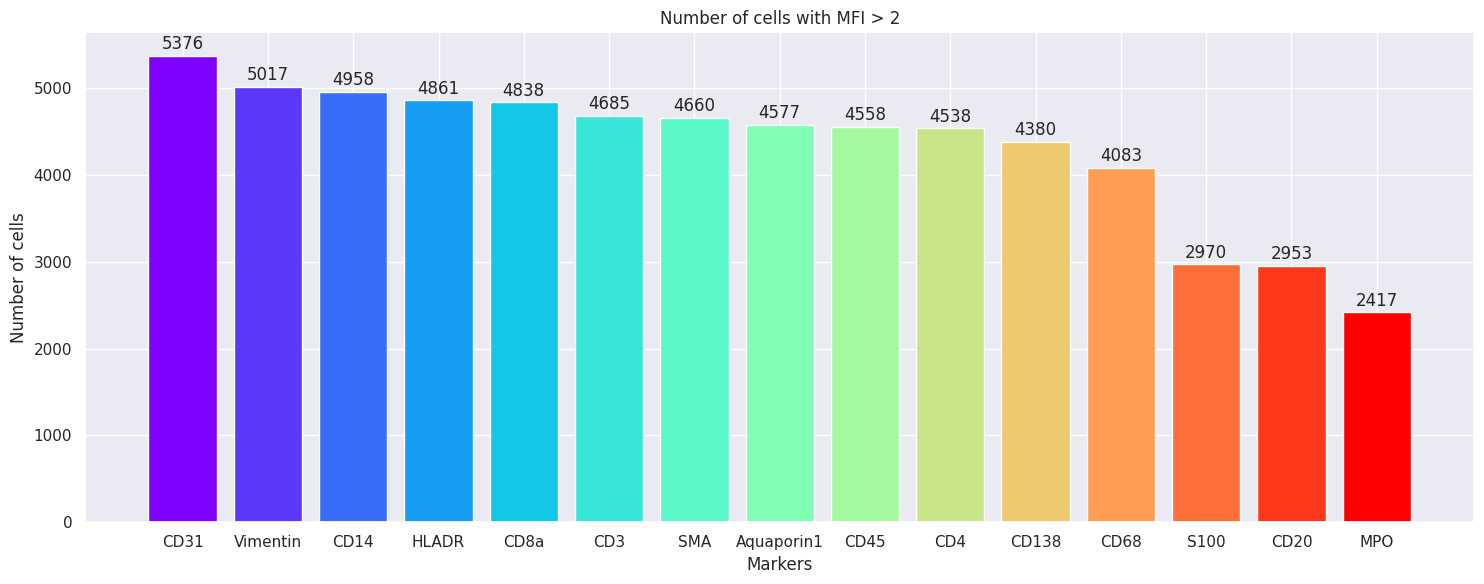

Saved bar chart to: /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/Histogram_main_markers.png


In [137]:

# --- Configurable threshold and output path ---
THRESH = 2
out_dir = Path(path_main_clust)
out_dir.mkdir(parents=True, exist_ok=True)
out_png = out_dir / "Histogram_main_markers.png"

# Ensure numeric input (coerce non-numeric to NaN, then compare)
df_num = df_mfi_select.apply(pd.to_numeric, errors="coerce")

# Per-marker counts of cells above threshold (ignores NaN automatically)
counts = (df_num > THRESH).sum().astype(int)

# Sort descending for readability
counts_sorted = counts.sort_values(ascending=False)

# Colors (rainbow); feel free to swap for a colorblind-friendly colormap if needed
colors = plt.cm.rainbow(np.linspace(0, 1, len(counts_sorted)))

# Plot
plt.figure(figsize=(15, 6))
ax = plt.gca()
bars = ax.bar(counts_sorted.index, counts_sorted.values, color=colors)

ax.set_title(f"Number of cells with MFI > {THRESH}")
ax.set_xlabel("Markers")
ax.set_ylabel("Number of cells")

# If there are many markers, angle labels for readability
if len(counts_sorted) > 20:
    plt.xticks(rotation=45, ha="right")
else:
    plt.xticks(rotation=0)

# Add value labels on bars (use bar_label if available)
try:
    ax.bar_label(bars, labels=[str(v) for v in counts_sorted.values], padding=2)
except Exception:
    # Fallback manual text placement (older Matplotlib)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, h, f"{int(h)}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved bar chart to: {out_png}")


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


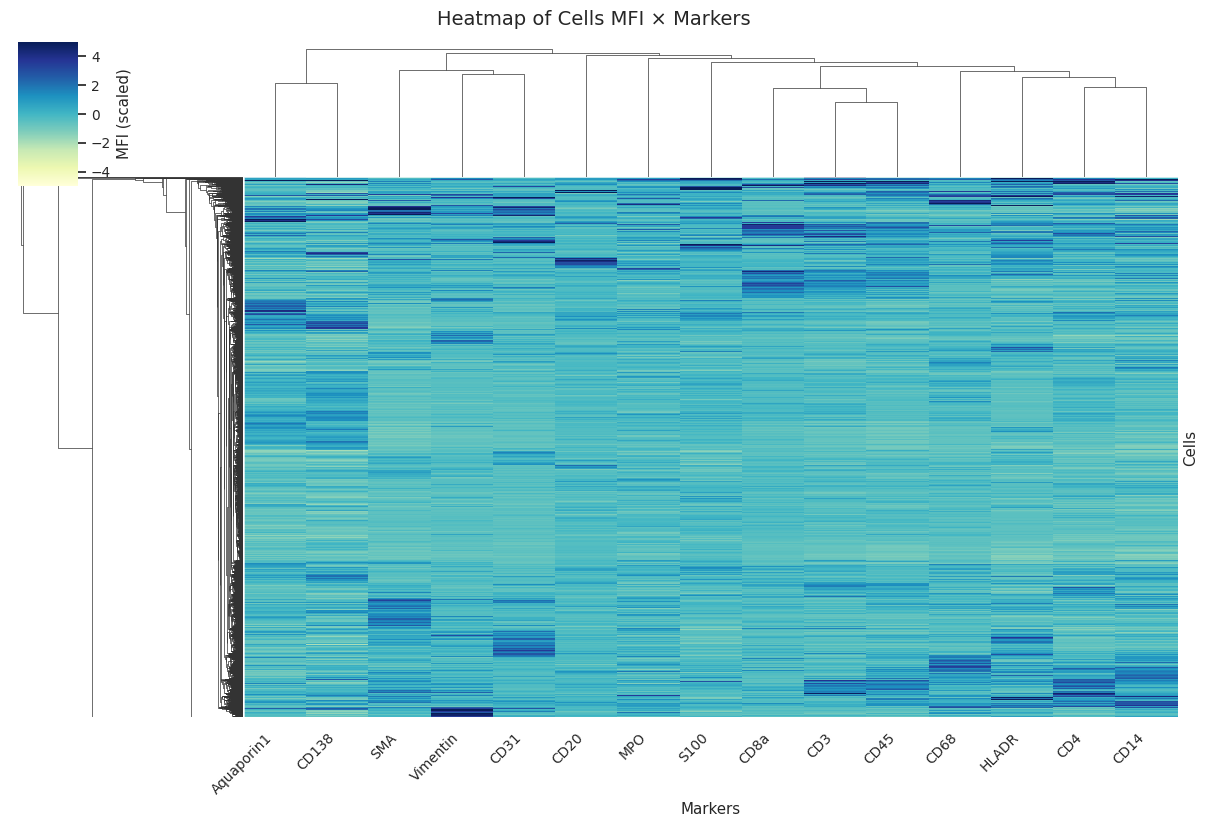

Saved heatmap to: /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/heatmap_cells.png


In [138]:
# --- Sampling (fixed seed for reproducibility) ---
df_sample = df_mfi_select.sample(n=15000, random_state=42)

# Optional: z-score per marker to balance scales (comment out if already standardized)
# df_sample = (df_sample - df_sample.mean()) / df_sample.std(ddof=0)

# --- Aesthetic defaults ---
sns.set_theme(context="notebook", style="white")
sns.set(font_scale=0.9)

# --- Build a clustered heatmap ---
# You can tweak method/metric as needed (e.g., method="average", metric="euclidean")
cg = sns.clustermap(
    data=df_sample,
    cmap="YlGnBu",
    vmin=-5, vmax=5,                 # keep your original range; adjust if you z-score
    xticklabels=True, yticklabels=False,
    linewidths=0,                    # cleaner tiles
    col_cluster=True, row_cluster=True,
    method="average", metric="euclidean",
    figsize=(12, 8),
    cbar_kws={"label": "MFI (scaled)"}
)

# --- Title + layout polish ---
cg.fig.suptitle("Heatmap of Cells MFI × Markers", fontsize=14, y=1.02)
cg.ax_heatmap.set_xlabel("Markers")
cg.ax_heatmap.set_ylabel("Cells")

# Rotate x tick labels for readability
plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

# Light frame & clean spines
for spine in cg.ax_heatmap.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

# --- Save nicely ---
out_dir = Path(path_main_clust)
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "heatmap_cells.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved heatmap to: {out_path}")


### Coexpression of the markers in the whole dataset

#### Functions

In [ ]:
def plot_density_df(df, marker_x, marker_y, path_out,
                    palette='tab10',
                    x_thresh=None, y_thresh=None,
                    ):
    """
    Trace la densité 2D d'un couple de marqueurs et ajoute :
      - Lignes seuils rouges (x_thresh, y_thresh)
      - Un résumé des comptes et pourcentages :
        X+, Y+, double+, double-
    """

    plt.figure(figsize=(8, 6))
    x = df[marker_x].values
    y = df[marker_y].values

    # Calcul de la densité locale
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Trier les points (les plus denses au-dessus)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter coloré selon densité
    sc = plt.scatter(x, y, c=z, cmap='viridis', s=3, edgecolor='none', alpha=0.7)

    # Densité 2D contours
    sns.kdeplot(x=x, y=y, levels=5, linewidths=1, color='black', alpha=0.6)

    # Ajouter lignes seuils si données
    if x_thresh is not None:
        plt.axvline(x=x_thresh, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    if y_thresh is not None:
        plt.axhline(y=y_thresh, color='red', linestyle='--', linewidth=1.5, alpha=0.8)

    # Calcul des populations selon les seuils
    if x_thresh is not None and y_thresh is not None:
        x_pos = x > x_thresh
        y_pos = y > y_thresh

        n_total = len(x)
        n_xpos = np.sum(x_pos)
        n_ypos = np.sum(y_pos)
        n_double_pos = np.sum(x_pos & y_pos)
        n_double_neg = np.sum(~x_pos & ~y_pos)

        # Calcul des pourcentages
        p_xpos = 100 * n_xpos / n_total
        p_ypos = 100 * n_ypos / n_total
        p_double_pos = 100 * n_double_pos / n_total
        p_double_neg = 100 * n_double_neg / n_total

        # Texte à afficher
        txt = (
            f"Total cells: {n_total}\n"
            f"{marker_x}+ : {n_xpos} ({p_xpos:.1f}%)\n"
            f"{marker_y}+ : {n_ypos} ({p_ypos:.1f}%)\n"
            f"Double + : {n_double_pos} ({p_double_pos:.1f}%)\n"
            f"Double - : {n_double_neg} ({p_double_neg:.1f}%)"
        )

        # Afficher dans le coin supérieur droit
        plt.text(0.98, 0.98, txt, transform=plt.gca().transAxes,
                 fontsize=9, color='white', fontweight='bold',
                 ha='right', va='top',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.4'))

    # Légendes et titre
    plt.xlabel(marker_x)
    plt.ylabel(marker_y)
    plt.title(f"{marker_x} vs {marker_y}")
    plt.colorbar(sc, label='Density')

    plt.tight_layout()
    plt.savefig(path_out + f"/{marker_x}_{marker_y}.png", dpi=300)
    plt.show()


#### Co-expression

In [ ]:
path_coexpression=path_main_clust+"coexpression_markers_all_cells/"
if os.path.isdir(path_coexpression)==False:
  os.mkdir(path_coexpression)

In [ ]:
df_mfi_pos=pd.read_csv(path_main_clust+"mfi_select_pos.csv")
df_mfi_pos=df_mfi_pos.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord"],axis=1)

In [ ]:
threshold=input("Enter the minimum threshold to select the markers: ")
threshold=float(threshold)

Enter the minimum threshold to select the markers: 1.5


In [ ]:
# Requirements:
# pip install tqdm


from itertools import combinations
from tqdm.auto import tqdm

# List of markers to pairwise plot
df_sample=df_mfi_pos.sample(n=5000, random_state=42)
list_marker = df_sample.columns.to_list()

# Total number of unique pairs (n choose 2) for progress tracking
total_pairs = len(list_marker) * (len(list_marker) - 1) // 2

# Iterate over all unique marker pairs with a progress bar
for marker1, marker2 in tqdm(
    combinations(list_marker, 2),
    total=total_pairs,
    desc="Plotting density for marker pairs",
    unit="pair"
):
    # Call your plotting function for each pair
    # Expected signature: plot_density_df(df, x_marker, y_marker)
    plot_density_df(df_sample, marker1, marker2,path_coexpression,x_thresh=threshold,y_thresh=threshold)
print(f"✅ The files can be found in the following folder:  {path_coexpression}")


Output hidden; open in https://colab.research.google.com to view.

### Reduction of dimension before clustering

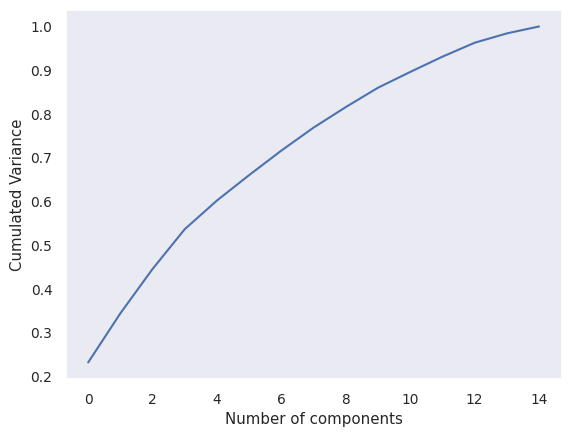

In [139]:
df_mfi_pos=pd.read_csv(path_main_clust+"mfi_select.csv")
exclude_column=["Cell_ID","area","centroid-0","centroid-1","ROI","coord"]
df_mfi_pos.drop(exclude_column, axis=1, inplace=True)
pca = PCA().fit(df_mfi_pos)
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulated Variance")
plt.grid()
plt.show()

In [140]:
nb_var=input("Enter the number of components to use: ")
nb_var=int(nb_var)

pca = PCA(n_components=nb_var)
X_pca = pca.fit_transform(df_mfi_pos)

df_pacmap=pd.DataFrame(X_pca)
df_pacmap.to_csv(path_main_clust+"pca_reduction_all.csv",index=False)
print(df_pacmap.shape)
df_pacmap.head()
print(f"✅ The files containing the DataFrames with this reduction of dimension:  {path_main_clust}pca_reduction_all.csv")

Enter the number of components to use: 14
(117556, 14)
✅ The files containing the DataFrames with this reduction of dimension:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/pca_reduction_all.csv


### Training of Phenographe
Clustering of cells according to the MFI of markers selected by the Phenograph algorithm to determine the main phenotypes



#### Functions

In [141]:
%pip install PhenoGraph
import phenograph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 108.9 MB/s eta 0:00:00


#### Execution

In [142]:
df_pca=pd.read_csv(path_main_clust+"pca_reduction_all.csv")
df_mfi_pos=pd.read_csv(path_main_clust+"mfi_select_pos.csv")
communities, graph, Q = phenograph.cluster(df_pca)
print("Number of clusters: "+str(len(np.unique(communities))))
df_mfi_pos["cluster"]=communities
df_mfi_pos.to_csv(path_main_clust+"/mfi_corrected_cluster.csv",index=False)
print(f"✅ This dataframe with the clusters can be found in the following folder:  {path_main_clust}mfi_corrected_cluster.csv")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 110.24017119407654 seconds
Jaccard graph constructed in 16.552483797073364 seconds
Wrote graph to binary file in 2.9679677486419678 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.817755
After 3 runs, maximum modularity is Q = 0.819925
Louvain completed 23 runs in 241.52384424209595 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 372.5861976146698 seconds
Number of clusters: 20
✅ This dataframe with the clusters can be found in the following folder:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/mfi_corrected_cluster.csv


### Representation of the importance of the mean MFI of each marker across cells in each cluster using a heatmap

#### Functions

In [143]:
def heatmap_histo(df, name_value, title, path, threshold, vmin, vmax):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from matplotlib.gridspec import GridSpec
    from scipy.cluster.hierarchy import linkage, leaves_list

    sns.set(font_scale=1)

    # --- Data ---
    data = df.groupby(name_value).mean()
    counts = df[name_value].value_counts().sort_index()

    linkage_result = linkage(data, method="ward")
    order = leaves_list(linkage_result)
    data = data.iloc[order]
    counts = counts.iloc[order]

    n_clusters = len(data)
    fig = plt.figure(figsize=(10, max(6, n_clusters * 0.4)))
    fig.patch.set_facecolor('white')
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1.2, 5], wspace=0.02)

    # --- Histogram ---
    ax_bar = fig.add_subplot(gs[0])
    y_positions = [i + 0.5 for i in range(n_clusters)]

    bars = ax_bar.barh(
        y=y_positions,
        width=counts.values,
        height=1,
        color='gray'
    )

    # Add cell counts inside the histogram
    for y, count in zip(y_positions, counts.values):
        ax_bar.text(
            count - 1,
            y,
            str(count),
            va='center',
            ha='right',
            fontsize=8
        )

    ax_bar.set_yticks([])
    ax_bar.invert_xaxis()
    ax_bar.set_xlabel("")
    ax_bar.set_xticks([])
    ax_bar.xaxis.set_label_position('top')
    ax_bar.set_facecolor('none')
    ax_bar.yaxis.set_ticks_position('none')

    for spine in ['top', 'right', 'bottom']:
        ax_bar.spines[spine].set_visible(False)

    # --- Heatmap (without colorbar) ---
    ax_heatmap = fig.add_subplot(gs[1])
    heatmap = sns.heatmap(
        data,
        ax=ax_heatmap,
        vmin=vmin,
        vmax=vmax,
        cmap="vlag",
        linewidths=0.5,
        linecolor='gray',
        xticklabels=True,
        yticklabels=False,
        cbar=False   # cbar created separately
    )

    # Y-axis ticks on the right side
    ax_heatmap.set_yticks([i + 0.5 for i in range(n_clusters)])
    ax_heatmap.set_yticklabels(data.index, fontsize=12)
    ax_heatmap.yaxis.tick_right()
    ax_heatmap.yaxis.set_label_position("right")

    # Align histogram and heatmap vertically
    ax_bar.set_ylim(ax_heatmap.get_ylim())

    # --- Red box highlighting values above threshold ---
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value > threshold:
                rect = Rectangle((j, i), 1, 1, linewidth=2,
                                 edgecolor='red', facecolor='none')
                ax_heatmap.add_patch(rect)

    # --- Main title ---
    fig.suptitle(title, fontsize=16, y=1.05)

    # --- Colorbar placed above the heatmap ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.cm as cm

    norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())
    sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
    sm.set_array([])

    # Custom position: [left, bottom, width, height]
    cax = fig.add_axes([0.13, 0.94, 0.3, 0.015])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)

    # --- Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for title and colorbar
    plt.savefig(path + f"Heatmap_{name_value}.png", bbox_inches='tight')
    plt.show()


#### Execution

In [144]:
df_mfi=pd.read_csv(path_main_clust+"/mfi_corrected_cluster.csv")
df_mfi=df_mfi.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord"],axis=1)
print(df_mfi.shape)
df_mfi.head()

(117556, 16)


,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,SMA,MPO,HLADR,CD45,CD14,cluster
0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,-0.244615,-0.553248,-0.302119,-0.280525,-0.524609,-0.026694,3
1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,0.317548,-0.669646,-0.581157,-0.567980,0.022562,1.635892,4
2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,-0.505190,-0.087198,-0.581157,0.619602,-0.524609,0.270712,4
3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,-0.012317,-0.223701,-0.581157,-0.609863,-0.332533,-0.542375,3
4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,-0.307195,-0.381405,-0.581157,-0.557700,-0.524609,1.345280,5


/tmp/ipython-input-4213136924.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for title and colorbar


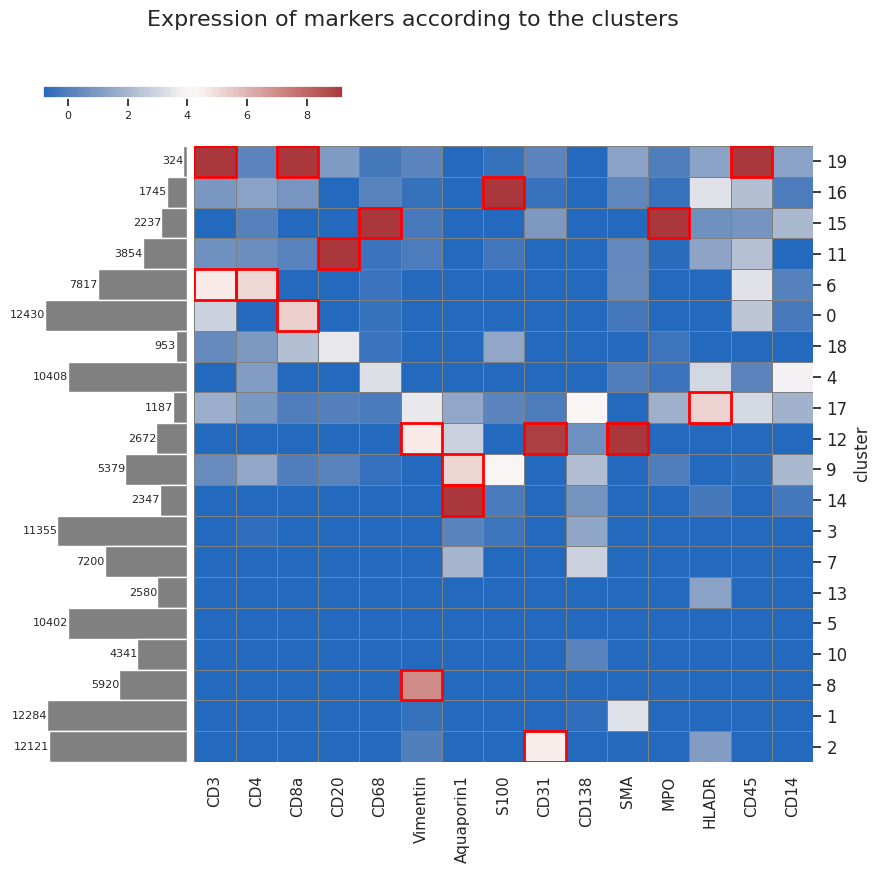

✅ The heatmap can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/


In [145]:
heatmap_histo(df_mfi,"cluster","Expression of markers according to the clusters",path_main_clust,threshold=1.5,vmin=0,vmax=3)
print(f"✅ The heatmap can be found there:  {path_main_clust}")


### Reduction of dimension of clusters

In [146]:
path_reduction_dimension_clust=path_reduction_dimension+"reduction_dimension_cluster/"
if os.path.isdir(path_reduction_dimension_clust)==False:
  os.mkdir(path_reduction_dimension_clust)

#### Functions

In [147]:
%pip install pacmap
import pacmap


In [148]:
def display_reduction_cluster(cluster,reduced_vector,lbl,size_picture,path,title,subtitle):
  list_colors=[]
  for i in range(reduced_vector.shape[0]):
    if lbl[i]==cluster:
     list_colors.append("red")
    else:
     list_colors.append("aquamarine")

  plt.figure(figsize=size_picture)
  plt.title(title,fontsize=40)
  plt.scatter(reduced_vector[:,0],reduced_vector[:,1],c=list_colors,s=1,label=cluster)
  plt.legend()
  plt.axis('off')
  plt.savefig(path+title+"_"+str(subtitle)+".png")
  plt.show()

In [149]:
def display_reduction_roi(reduced_vector,lbl,size_picture,path,title,subtitle):

  rgb_colors = {}
  for name, hex in matplotlib.colors.cnames.items():
    rgb_colors[name] = matplotlib.colors.to_rgb(hex)
  list_col=["red","blue","green","purple","yellow","aquamarine","brown","chartreuse","cornflowerblue","coral","darkolivegreen","darkorange","darkslateblue","deeppink","gold","greenyellow","crimson","indigo","fuchsia","lightsalmon","lightgray","maroon"]
  list_col2=["aquamarine","blue","blueviolet","brown","orange","red","cornflowerblue","coral","darkolivegreen","darkgoldenrod","darkslateblue","deeppink","gold","greenyellow","indigo","fuchsia","lightsalmon","lightgray","maroon"]
  list_col2=list(rgb_colors.keys())[5:]
  dico_pheno_num={}
  for i,v in enumerate(np.unique(lbl)):
    dico_pheno_num[v]=i

  list_colors=[]
  for i in range(reduced_vector.shape[0]):
    if lbl[i]=="None":
      list_colors.append("white")
    else:
      list_colors.append(list_col2[dico_pheno_num[lbl[i]]])

  fig = plt.figure(layout='constrained', figsize=size_picture)
  fig.suptitle(title,fontsize=40)
  subfigs = fig.subfigures(2,1,height_ratios=(5,1))
  ax=subfigs[0].subplots()
  ax.scatter(reduced_vector[:,0],reduced_vector[:,1],c=list_colors,s=1)
  ax.axis('off')

  list_clust=list(np.unique(lbl))
  if "None" in list_clust:
   list_clust.remove("None")
  axs=subfigs[1].subplots(1,len(list_clust))
  for n,ax2 in enumerate(axs):
    img=np.zeros((30,30,3))
    img[:,:]=rgb_colors[list_col2[dico_pheno_num[list_clust[n]]]]
    ax2.imshow(img)
    ax2.set_title(str(list_clust[n]))
    ax2.title.set_size(15)
    ax2.axis('off')
  subfigs[1].suptitle(subtitle,fontsize=20)
  fig.savefig(path+title+"_"+subtitle+".png")
  plt.show()

In [150]:

def plot_pacmap(df_pacmap,feature, figsize=(8, 6), savepath=None,title=""):
    # Order phenotypes by frequency (optional but nice for legend)
    pheno_counts = df_pacmap[feature].value_counts()
    phenotypes = pheno_counts.index.tolist()

    # Palette with as many distinct colors as phenotypes
    palette = sns.color_palette("tab20", n_colors=len(phenotypes))
    pheno_to_color = {ph: palette[i] for i, ph in enumerate(phenotypes)}

    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Plot phenotype by phenotype (gives more control than seaborn.scatterplot)
    for ph in phenotypes:
        sub = df_pacmap[df_pacmap[feature] == ph]
        ax.scatter(
            sub['0'],
            sub['1'],
            s=8,
            color=pheno_to_color[ph],
            alpha=0.7,
            edgecolor="none",
            label=f"{ph} (n={len(sub)})"
        )

    ax.set_xlabel("PaCMAP 1", fontsize=11)
    ax.set_ylabel("PaCMAP 2", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # Legend outside the plot
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=9,
        markerscale=4.0,
        title=feature
    )

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"✅ The graph can be found there:  {savepath}")

    plt.show()




#### Display the cluster on a reduction of dimension

In [151]:
df_mfi=pd.read_csv(path_main_clust+"mfi_corrected_cluster.csv")
labels_km=df_mfi["cluster"]
df_pacmap=df_mfi.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord","cluster"],axis=1)
print(df_mfi.shape)
print(df_mfi.columns)
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
X_transformed = embedding.fit_transform(df_pacmap, init="pca")
X_transformed.shape

(117556, 22)
Index(['CD3', 'CD4', 'CD8a', 'CD20', 'CD68', 'Vimentin', 'Aquaporin1', 'S100',
       'CD31', 'CD138', 'SMA', 'MPO', 'HLADR', 'CD45', 'CD14', 'Cell_ID',
       'area', 'centroid-0', 'centroid-1', 'ROI', 'coord', 'cluster'],
      dtype='object')


(117556, 2)

In [152]:
df_pacmap=pd.DataFrame(X_transformed,columns=["0","1"])
df_pacmap.to_csv(path_main_clust+"pacmap_reduction_all.csv")
print(df_pacmap.shape)
df_pacmap.head()

(117556, 2)


,0,1
0,-1.549121,-3.013407
1,1.789224,1.040830
2,2.051421,0.836500
3,-3.769869,-5.742240
4,0.518549,-0.649879


✅ The graph can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/reduction_dimension/Pacmap_clusters


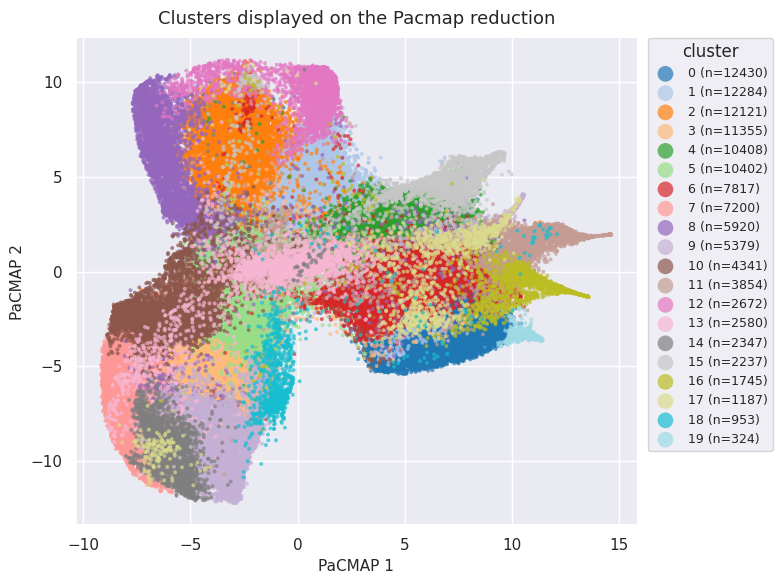

In [153]:
df_pacmap["cluster"]=df_mfi["cluster"]
plot_pacmap(df_pacmap,"cluster", savepath=path_reduction_dimension+"Pacmap_clusters",title="Clusters displayed on the Pacmap reduction")


In [154]:
path_reduction_dimension_cluster=path_reduction_dimension+"reduction_dimension_cluster/"
if os.path.isdir(path_reduction_dimension_cluster)==False:
  os.mkdir(path_reduction_dimension_cluster)

In [155]:

labels_km = list(df_pacmap["cluster"])

for cluster in df_pacmap["cluster"].unique():
    # Work on a copy
    df = df_pacmap.copy()

    # Create a new column used for coloring:
    # current cluster = its ID, others = "other"
    df["cluster_display"] = np.where(
        df["cluster"] == cluster,
        str(cluster),
        "other"
    )

    savepath = os.path.join(
        path_reduction_dimension_cluster,
        f"cluster_{cluster}.png"
    )

    plot_pacmap(
        df,
        "cluster_display",
        savepath=savepath,
        title=f"Cluster {cluster} displayed on the PaCMAP reduction"
    )



Output hidden; open in https://colab.research.google.com to view.

### Representation of clusters on the ROI

#### Functions

In [156]:
def draw_outline(img, list_pixel, color=[255, 255, 0], width=1):
    # Convertir en RGB si image grayscale
    if len(img.shape) == 2:
        img = np.stack([img]*3, axis=-1)

    # Créer un masque binaire à partir de list_pixel
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for pixel in list_pixel:
        x, y = map(int, pixel.split(","))
        if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
            mask[x, y] = 255

    # Trouver les contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dessiner les contours sur l'image
    img = cv2.drawContours(img, contours, -1, color, thickness=width)

    return img


#### Representation on the biopsies

In [157]:
processing=input("Enter 1 or 2 to choose the image processing used to display the clusters: ")

Enter 1 or 2 to choose the image processing used to display the clusters: 2


In [158]:
path_representation=path_main_clust+"representation_cluster_roi/"
if os.path.isdir(path_representation)==False:
  os.mkdir(path_representation)
path_img=path+"images/img_processing_"+processing+"/Marker/"

In [159]:
df_mfi=pd.read_csv(path_main_clust+"mfi_corrected_cluster.csv")
print(df_mfi.shape)
df_mfi.head()

(117556, 22)


,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,...,HLADR,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord,cluster
0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,-0.244615,...,-0.280525,-0.524609,-0.026694,0,28.0,3.928571,1.250000,19U08731 a,"0,0;0,1;1,0;1,1;1,2;2,0;2,1;2,2;3,0;3,1;3,2;3,...",3
1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,0.317548,...,-0.567980,0.022562,1.635892,1,52.0,2.653846,15.788462,19U08731 a,"0,13;0,14;0,15;0,16;0,17;0,18;0,19;1,12;1,13;1...",4
2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,-0.505190,...,0.619602,-0.524609,0.270712,2,21.0,1.000000,39.000000,19U08731 a,"0,36;0,37;0,38;0,39;0,40;0,41;0,42;1,36;1,37;1...",4
3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,-0.012317,...,-0.609863,-0.332533,-0.542375,3,53.0,2.396226,87.433962,19U08731 a,"0,84;0,85;0,86;0,87;0,88;0,89;0,90;0,91;1,83;1...",3
4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,-0.307195,...,-0.557700,-0.524609,1.345280,4,22.0,1.272727,95.045455,19U08731 a,"0,92;0,93;0,94;0,95;0,96;0,97;0,98;1,93;1,94;1...",5


In [160]:
df_cluster=df_mfi.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord"],axis=1)
df_cluster = df_cluster.groupby("cluster").mean()
df_max = df_cluster.idxmax(axis=1)
for i in range(df_max.shape[0]):
    df_cluster.loc[i, df_max[i]] = 0
df_max2 = df_cluster.idxmax(axis=1)

list_roi = df_mfi["ROI"].unique()

for roi in list_roi:
    for cluster in range(len(df_mfi["cluster"].unique())):
        #if not os.path.isfile(path_rep + str(cluster) + "/" + roi + ".png"):

            marker_max = df_max.iloc[cluster]
            marker_max2 = df_max2.iloc[cluster]

            if not os.path.isdir(path_representation + str(cluster)):
                os.mkdir(path_representation + str(cluster))

            print("Cluster:" + str(cluster))
            print("------ " + roi)
            img_marker = plt.imread(path_img + marker_max + "/" + roi + ".png")
            img_marker2 = plt.imread(path_img + marker_max2 + "/" + roi + ".png")
            img_marker_tot = np.zeros((img_marker.shape[0], img_marker.shape[1], 3))
            img_marker_tot[:, :, 1] = np.arcsinh(img_marker2)
            img_marker_tot[:, :, 0] = np.arcsinh(img_marker)

            # Binariser img_marker à 0.4 (comme dans ton code original)
            img_marker_bin = np.where(img_marker > 0.4, 1, 0)

            img_cluster = np.zeros(img_marker.shape)

            for i in range(df_mfi.shape[0]):
                if df_mfi.iloc[i]["cluster"] == cluster and df_mfi.loc[i, "ROI"] == roi:
                    list_pixel = df_mfi.iloc[i]["coord"].split(";")[:-1]
                    img_marker_tot = draw_outline(img_marker_tot, list_pixel, [255,255,255],1)
                    img_marker = draw_outline(np.arcsinh(img_marker*10), list_pixel, [57, 255, 20], 1)
                    img_marker2 = draw_outline(np.arcsinh(img_marker2*10), list_pixel, [57, 255, 20], 1)

                    for pixel in list_pixel:
                        coord = pixel.split(",")
                        img_cluster[int(coord[0]), int(coord[1])] = 255

            plt.figure(figsize=(16, 8))  # taille plus grande

            plt.subplot(1, 4, 1)
            plt.title(f"Cluster: {cluster}")
            plt.imshow(img_cluster, cmap="gray")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title(f"Red: {marker_max}, Green: {marker_max2}")
            plt.imshow(img_marker_tot)
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title(marker_max)
            plt.imshow(img_marker)
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title(marker_max2)
            plt.imshow(img_marker2)
            plt.axis('off')

            plt.subplots_adjust(wspace=2, hspace=2)  # supprimer espaces entre images
            plt.tight_layout(pad=0)  # supprimer padding global

            plt.savefig(path_representation + str(cluster) + "/" + roi + ".png", bbox_inches='tight', pad_inches=0)
            plt.close()


Cluster:0
------ 19U08731 a


Cluster:1
------ 19U08731 a


Cluster:2
------ 19U08731 a


KeyboardInterrupt: 

### Histogramme overlay

#### Functions

In [161]:
def plot_mfi_histogram_by_cluster(df, marker, cluster_col='cluster', bins=None, offset=0.1, colors=None):

    clusters = df[cluster_col].unique()
    clusters.sort()

    if colors is None:
        colors = plt.cm.tab10.colors

    # Préparation des données
    data_by_cluster = {
        f'Cluster {c}': df[df[cluster_col] == c][marker].dropna().values
        for c in clusters
    }

    # Calcul des bins
    all_values = np.concatenate(list(data_by_cluster.values()))
    if bins is None:
        bins = np.linspace(np.min(all_values), np.max(all_values), 100)

    plt.figure(figsize=(40, 30))

    for i, (label, data) in enumerate(data_by_cluster.items()):
        hist, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        color = colors[i % len(colors)]

        plt.plot(bin_centers, hist + i * offset, color=color, linewidth=2, label=label)
        plt.fill_between(bin_centers, i * offset, hist + i * offset, color=color, alpha=0.3)

    plt.xlabel(marker,fontsize=30)
    plt.ylabel('Density + offset',fontsize=30)
    plt.title(f'Distribution of {marker} by Cluster',fontsize=40)
    plt.xlim(-2,10)
    #plt.legend()
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(path_histo_overlay+marker+".png")
    plt.show()


#### Histogram overlay

In [162]:
path_histo_overlay=path_main_clust+"histograme_overlay/"
if os.path.isdir(path_histo_overlay)==False:
  os.mkdir(path_histo_overlay)

In [163]:
df_mfi=pd.read_csv(path_main_clust+"/mfi_corrected_cluster.csv")
df_mfi=df_mfi.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord"],axis=1)

In [164]:
for marker in df_mfi.columns[:-1]:
  plot_mfi_histogram_by_cluster(df_mfi, marker,offset=1)
print(f"✅ The files are available here:  {path_histo_overlay}")


Output hidden; open in https://colab.research.google.com to view.

### Graphs showing the presence of markers within clusters and vice versa

#### Functions

In [165]:
def plot_mfi_cluster(df_mfi,path_file):

  list_cluster=sorted(df_mfi["cluster"].unique())
  for cluster in list_cluster:
     print("Cluster: "+str(cluster))
     list_data=[]
     nb_cell=len(df_mfi.loc[df_mfi.loc[:,"cluster"]==cluster])
     nb_tot=df_mfi.shape[0]
     list_marker=df_mfi.columns[:-1]
     list_col=[]
     for m in list_marker:
       list_m=list(df_mfi.loc[df_mfi.loc[:,"cluster"]==cluster][m])
       list_data.append(list_m)
     for i in range(len(list_data)):
       if np.mean(list_data[i])>1.5:
        list_col.append("red")
       else:
        list_col.append("blue")
     pos=[float(p) for p in range(0,len(list_data))]
     fig,ax = plt.subplots(1,1,figsize=(60,10))
     violin=ax.violinplot(list_data,pos,showextrema=False,showmedians=True)
     c=0
     for pc in violin['bodies']:
       pc.set_facecolor(list_col[c])
       c+=1
     ax.set_title("Cluster: "+str(cluster)+" ( Nb of cells "+str(nb_cell)+" / "+str(nb_tot)+" )",fontsize=40)
     ax.set_xticks(np.arange(0,len(list_marker)),list_marker,size=25)
     ax.tick_params(axis='y', labelsize=20)
     plt.ylabel("Z-score",size=30)
     plt.savefig(path_file+str(cluster)+".png")


In [166]:
def plot_mfi_marker(df_mfi,path_file):

  list_marker=list(df_mfi.columns[:-1])
  for marker in list_marker:
     print("marker: "+str(marker))
     list_data=[]
     list_cluster=sorted(df_mfi["cluster"].unique())
     for c in list_cluster:
       list_c=list(df_mfi.loc[df_mfi.loc[:,"cluster"]==c][marker])
       list_data.append(list_c)
     list_col=[]
     for i in range(len(list_data)):
        if np.mean(list_data[i])>1.5:
          list_col.append("red")
        else:
          list_col.append("blue")
     pos=[float(p) for p in range(0,len(list_data))]
     fig,ax = plt.subplots(1,1,figsize=(90,10))
     violin=plt.violinplot(list_data,pos,showextrema=False,showmedians=True)
     c=0
     for pc in violin['bodies']:
       pc.set_facecolor(list_col[c])
       c+=1
     ax.set_title("Marqueur: "+marker,fontsize=40)
     plt.ylabel("Z-score",size=30)
     ax.set_xticks(np.arange(0,len(list_cluster)),list_cluster,size=25)
     plt.savefig(path_file+str(marker)+".png")


#### plot MFI

In [167]:
path_plot_clust=path_main_clust+"plot_mfi_cluster/"
path_plot_marker=path_main_clust+"plot_mfi_marker/"

In [168]:
if os.path.isdir(path_plot_clust)==False:
  os.mkdir(path_plot_clust)
if os.path.isdir(path_plot_marker)==False:
  os.mkdir(path_plot_marker)

In [169]:
df_mfi=pd.read_csv(path_main_clust+"/mfi_corrected_cluster.csv")
df_mfi=df_mfi.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord"],axis=1)
print(df_mfi.shape)
df_mfi.head()

(117556, 16)


,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,SMA,MPO,HLADR,CD45,CD14,cluster
0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,-0.244615,-0.553248,-0.302119,-0.280525,-0.524609,-0.026694,3
1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,0.317548,-0.669646,-0.581157,-0.567980,0.022562,1.635892,4
2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,-0.505190,-0.087198,-0.581157,0.619602,-0.524609,0.270712,4
3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,-0.012317,-0.223701,-0.581157,-0.609863,-0.332533,-0.542375,3
4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,-0.307195,-0.381405,-0.581157,-0.557700,-0.524609,1.345280,5


In [170]:
plot_mfi_cluster(df_mfi,path_plot_clust)
print(f"✅ The files are available here:  {path_plot_clust}")

Output hidden; open in https://colab.research.google.com to view.

In [171]:
plot_mfi_marker(df_mfi,path_plot_marker)
print(f"✅ The files are available here:  {path_plot_marker}")

Output hidden; open in https://colab.research.google.com to view.

### Phenotypes annotation
Annotation of clusters using MFI graphs, dimensionality reductions, heatmaps, and cluster representations on biopsies



In [172]:
df_mfi=pd.read_csv(path_main_clust+"/mfi_corrected_cluster.csv")
df_mfi_tot=pd.read_csv(path_clust+"mfi_corrected_arcsinh_std.csv")

In [173]:

dict_pheno_cluster={}
for cluster in df_mfi["cluster"].unique():
  pheno=input("Enter the phenotype corresponding to the cluster "+str(cluster)+" :")
  if pheno not in dict_pheno_cluster.keys():
    dict_pheno_cluster[pheno]=[]
  dict_pheno_cluster[pheno].append(cluster)
print(dict_pheno_cluster)

KeyboardInterrupt: Interrupted by user

In [175]:
dict_cluster_pheno={}
for k in dict_pheno_cluster.keys():
  for v in dict_pheno_cluster[k]:
    if v not in dict_cluster_pheno.keys():
     dict_cluster_pheno[v]=k

In [176]:
df_mfi["phenotype"]=[dict_cluster_pheno[cluster] for cluster in df_mfi["cluster"]]
df_mfi.to_csv(path_main_clust+"mfi_pheno_no_filter.csv")
df_mfi.head()

,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,...,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord,cluster,phenotype
0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,-0.244615,...,-0.524609,-0.026694,0,28.0,3.928571,1.250000,19U08731 a,"0,0;0,1;1,0;1,1;1,2;2,0;2,1;2,2;3,0;3,1;3,2;3,...",3,No
1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,0.317548,...,0.022562,1.635892,1,52.0,2.653846,15.788462,19U08731 a,"0,13;0,14;0,15;0,16;0,17;0,18;0,19;1,12;1,13;1...",4,Mono|Macro
2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,-0.505190,...,-0.524609,0.270712,2,21.0,1.000000,39.000000,19U08731 a,"0,36;0,37;0,38;0,39;0,40;0,41;0,42;1,36;1,37;1...",4,Mono|Macro
3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,-0.012317,...,-0.332533,-0.542375,3,53.0,2.396226,87.433962,19U08731 a,"0,84;0,85;0,86;0,87;0,88;0,89;0,90;0,91;1,83;1...",3,No
4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,-0.307195,...,-0.524609,1.345280,4,22.0,1.272727,95.045455,19U08731 a,"0,92;0,93;0,94;0,95;0,96;0,97;0,98;1,93;1,94;1...",5,No


### Filter phenotypes according to a minimum MFI

In [196]:
df_pheno=pd.read_csv(path_main_clust+"mfi_pheno_no_filter.csv")
df_pheno.head()

,Unnamed: 0,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,...,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord,cluster,phenotype
0,0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,...,-0.524609,-0.026694,0,28.0,3.928571,1.250000,19U08731 a,"0,0;0,1;1,0;1,1;1,2;2,0;2,1;2,2;3,0;3,1;3,2;3,...",3,No
1,1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,...,0.022562,1.635892,1,52.0,2.653846,15.788462,19U08731 a,"0,13;0,14;0,15;0,16;0,17;0,18;0,19;1,12;1,13;1...",4,Mono|Macro
2,2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,...,-0.524609,0.270712,2,21.0,1.000000,39.000000,19U08731 a,"0,36;0,37;0,38;0,39;0,40;0,41;0,42;1,36;1,37;1...",4,Mono|Macro
3,3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,...,-0.332533,-0.542375,3,53.0,2.396226,87.433962,19U08731 a,"0,84;0,85;0,86;0,87;0,88;0,89;0,90;0,91;1,83;1...",3,No
4,4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,...,-0.524609,1.345280,4,22.0,1.272727,95.045455,19U08731 a,"0,92;0,93;0,94;0,95;0,96;0,97;0,98;1,93;1,94;1...",5,No


In [183]:

SEUIL_INCLUSION=float(input("Enter the threshold value to select the positive cells: "))
SEUIL_EXCLUSION=float(input("Enter the threshold value to exclude a cell: "))


Enter the threshold value to select the positive cells: 0.7
Enter the threshold value to exclude a cell: 1


In [197]:
dico_any_marker={}


dico_exclude_markers={}
for pheno in np.unique(df_pheno["phenotype"]):
  if pheno!="No":
    list_marker=input(f"Enter the markers specific to this {pheno} separate by a comma: ").split(",")
    list_marker_excluded=input(f"Enter the markers to exclude for {pheno} separate by a comma: ").split(",")
    dico_any_marker[pheno]=list_marker
    dico_exclude_markers[pheno]=list_marker_excluded


Enter the markers specific to this DC separate by a comma: S100
Enter the markers to exclude for DC separate by a comma: 
Enter the markers specific to this Endothelium separate by a comma: CD31
Enter the markers to exclude for Endothelium separate by a comma: 
Enter the markers specific to this Epithelium separate by a comma: Aquaporin1,CD138
Enter the markers to exclude for Epithelium separate by a comma: 
Enter the markers specific to this LB separate by a comma: CD20
Enter the markers to exclude for LB separate by a comma: CD3
Enter the markers specific to this LT4 separate by a comma: CD4
Enter the markers to exclude for LT4 separate by a comma: CD20
Enter the markers specific to this LT8 separate by a comma: CD8a
Enter the markers to exclude for LT8 separate by a comma: CD20
Enter the markers specific to this Mono|Macro separate by a comma: CD68
Enter the markers to exclude for Mono|Macro separate by a comma: Aquaporin1,CD3
Enter the markers specific to this Stromal separate by a

In [198]:

# Chargement
df_pheno = pd.read_csv(path_main_clust + "mfi_pheno_no_filter.csv")
print("Phénotypes initiaux à 'No':", (df_pheno["phenotype"] == "No").sum())


# Fonction de validation
def validate_pheno(row):
    pheno = row["phenotype"]

    if pheno == "No":
        return "No"

    # Vérification exclusion d'abord
    if pheno in dico_exclude_markers:
        if any(marker in row and row[marker] > SEUIL_EXCLUSION for marker in dico_exclude_markers[pheno]):
            return "No"


    # Au moins un marqueur doit être positif
    if pheno in dico_any_marker:
        if any(marker in row and row[marker] > SEUIL_INCLUSION for marker in dico_any_marker[pheno]):
            return pheno
        else:
            return "No"

    return "No"

# Application
df_pheno["phenotype"] = df_pheno.apply(validate_pheno, axis=1)

# Résumé
print("Phénotypes filtrés à 'No':", (df_pheno["phenotype"] == "No").sum())
print("Phénotypes restants:", (df_pheno["phenotype"] != "No").sum())


Phénotypes initiaux à 'No': 43102
Phénotypes filtrés à 'No': 59747
Phénotypes restants: 57809


In [199]:
df_pheno.to_csv(path_main_clust+"mfi_pheno.csv",index=False)
print(f"✅ The filtered dataframe is available here:  {path_main_clust}mfi_mheno.csv")

✅ The filtered dataframe is available here:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/mfi_mheno.csv


### Display the colored mask of the cells on the biopsies

In [188]:
path_img_pheno=path_main_clust+"images_phenotypes/"

if os.path.isdir(path_img_pheno)==False:
  os.mkdir(path_img_pheno)

In [189]:

df_pheno=pd.read_csv(path_main_clust+"mfi_pheno.csv")
df_pheno=df_pheno[df_pheno["phenotype"]!="No"]
print(df_pheno.shape)
df_pheno.head()

(47275, 24)


,Unnamed: 0,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,...,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord,cluster,phenotype
6,6,0.778339,0.759402,-0.208560,-0.009069,0.286658,3.495814,-0.464098,0.272401,-0.653640,...,-0.369118,0.202277,6,38.0,2.684211,137.026316,19U08731 a,"0,135;0,136;0,137;0,138;0,139;1,134;1,135;1,13...",8,Stromal
7,7,-0.555585,0.632461,-0.109179,-0.334868,-0.370041,4.386763,1.124589,0.180772,1.217587,...,-0.320529,1.359465,7,72.0,3.750000,159.555556,19U08731 a,"0,156;0,157;0,158;0,159;0,160;0,161;0,162;1,15...",8,Stromal
17,17,-0.173735,2.129136,0.158678,0.368673,0.235428,0.296328,2.184603,3.160111,-0.115885,...,-0.267532,2.185914,17,17.0,0.941176,407.352941,19U08731 a,"0,405;0,406;0,407;0,408;0,409;0,410;1,405;1,40...",9,Epithelium
20,20,-0.130527,-0.542759,-0.343278,0.261607,-0.140214,0.891493,-0.208468,-0.544138,-0.299819,...,-0.231369,0.391717,20,47.0,2.744681,516.063830,19U08731 a,"0,513;0,514;0,515;0,516;0,517;0,518;0,519;1,51...",8,Stromal
24,24,-0.107224,0.377040,-0.104237,-0.054089,1.386149,0.021131,-1.177552,7.702396,-0.563020,...,1.396350,-0.145844,25,59.0,4.728814,123.796610,19U08731 a,"1,124;1,125;1,126;2,123;2,124;2,125;2,126;2,12...",16,DC


#### Functions

In [190]:
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
# Parsing coordonnées
def parse_coord_string(coord_str):
    if pd.isna(coord_str):
        return []

    points = []
    for pair in str(coord_str).split(";"):
        pair = pair.strip()
        if not pair:
            continue
        try:
            x_str, y_str = pair.split(",")
            y = int(float(x_str.replace(",", ".").replace(" ", "")))
            x = int(float(y_str.replace(",", ".").replace(" ", "")))
            points.append((x, y))
        except ValueError:
            continue
    return points

# ---------- Générer la légende comme image PIL ----------
def create_legend_image(pheno_to_color, fontsize=10):
    """
    Construit une légende (patch + texte) sous forme d'image PIL.
    """
    # Construire patches pour matplotlib
    patches = [
        mpatches.Patch(color=np.array(c[:3]) / 255.0, label=str(ph))
        for ph, c in pheno_to_color.items()
    ]

    # Générer la figure Matplotlib
    fig, ax = plt.subplots(figsize=(3, len(patches) * 0.5))
    ax.axis("off")

    fig.legend(handles=patches, loc="upper left", fontsize=fontsize, title="Phenotypes")

    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight", transparent=True)
    plt.close(fig)

    buf.seek(0)
    legend_img = Image.open(buf).convert("RGBA")
    return legend_img


# ---------- Colle la légende à l’image ----------
def attach_legend_to_image(base_image, legend_image, position="right", padding=20):
    """
    Fusionne base_image et legend_image en une seule image.
    position = "right" ou "bottom"
    """
    bw, bh = base_image.size
    lw, lh = legend_image.size

    if position == "right":
        # nouvelle taille
        new_img = Image.new("RGBA", (bw + lw + padding, max(bh, lh)), (255, 255, 255, 255))
        new_img.paste(base_image, (0, 0))
        new_img.paste(legend_image, (bw + padding, 0), legend_image)

    elif position == "bottom":
        new_img = Image.new("RGBA", (max(bw, lw), bh + lh + padding), (255, 255, 255, 255))
        new_img.paste(base_image, (0, 0))
        new_img.paste(legend_image, (0, bh + padding), legend_image)

    return new_img
def build_color_mapping(df, custom_colors=None):
    """
    Retourne un mapping phenotype -> couleur RGBA.
    Si custom_colors est fourni, l'utilise.
    Sinon génère automatiquement des couleurs vives.
    """
    phenotypes = df["phenotype"].unique()

    if custom_colors is not None:
        # On convertit les couleurs nommées => RGB
        from matplotlib.colors import to_rgba

        pheno_to_color = {}
        for ph in phenotypes:
            if ph in custom_colors:
                r, g, b, a = to_rgba(custom_colors[ph])
                pheno_to_color[ph] = (int(r*255), int(g*255), int(b*255), 140)
            else:
                # couleur par défaut si absente du dictionnaire
                pheno_to_color[ph] = (255, 255, 255, 140)
        return pheno_to_color

    # Sinon: colormap vive tab10
    cmap = plt.get_cmap("tab10", len(phenotypes))
    pheno_to_color = {}
    for i, ph in enumerate(phenotypes):
        r, g, b, _ = cmap(i)
        # boost saturation
        r = min(1, r * 1.3)
        g = min(1, g * 1.3)
        b = min(1, b * 1.3)
        pheno_to_color[ph] = (int(r*255), int(g*255), int(b*255), 140)

    return pheno_to_color

# ---------- Mise à jour dans draw_cells_for_roi ----------
def draw_cells_for_roi(df_roi,
                       roi,
                       path_img,
                       image_ext=".png",
                       custom_colors=None,
                       path_img_pheno=None,
                       save=True,
                       show=True,
                       alpha=160):

    pheno_to_color = build_color_mapping(df_roi, custom_colors)

    # Charger image base
    img_name = f"{roi}/CD4{image_ext}"
    img_path = os.path.join(path_img, img_name)
    base_img = Image.open(img_path).convert("RGBA")

    # Dessiner masques sur overlay
    overlay = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay, "RGBA")

    for _, row in df_roi.iterrows():
        coords = parse_coord_string(row["coord"])
        if len(coords) >= 3:
            draw.polygon(coords, fill=pheno_to_color[row["phenotype"]],
                         outline=pheno_to_color[row["phenotype"]])

    # Fusion
    masked_img = Image.alpha_composite(base_img, overlay)

    # ---------- Construire la légende PIL ----------
    legend_img = create_legend_image(pheno_to_color)

    # ---------- Coller légende à droite ----------
    final_img = attach_legend_to_image(masked_img, legend_img, position="right")

    # ---------- Sauvegarde ----------
    if save and path_img_pheno is not None:
        os.makedirs(path_img_pheno, exist_ok=True)
        save_path = os.path.join(path_img_pheno, f"{roi}{image_ext}")
        final_img.save(save_path)

    # ---------- Affichage ----------
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(final_img)
        plt.axis("off")
        plt.title(f"ROI : {roi}")
        plt.show()


#### Execution

In [191]:
dico_color = {
    "LB": "aliceblue",
    "LT4": "aqua",
    "LT8": "blue",
    "DC":"green",
    "Mono|Macro": "blueviolet",
    "Stromal": "darkorange",
    "Epithelium": "gold",
    "Endothelium": "red"
}

for roi_exemple in np.unique(df_pheno["ROI"]):
 df_roi_exemple = df_pheno[df_pheno["ROI"] == roi_exemple]

 draw_cells_for_roi(
    df_roi_exemple,
    roi_exemple,
    path_img=path_img_raw,
    image_ext=".tiff",
    custom_colors=dico_color,
    path_img_pheno=path_img_pheno,
    save=True,
    show=True,
    alpha=170
)


Output hidden; open in https://colab.research.google.com to view.

In [192]:
dico_pheno_num={}
list_pheno=input("Enter the phenotypes to display separated by a comma (the order must have a biological sens): ").split(",")
for i,pheno in enumerate(list_pheno):
  dico_pheno_num[pheno]=i


KeyboardInterrupt: Interrupted by user

### Heatmap of Phenotype

#### Functions

In [193]:
def heatmap_histo(df, name_value, title, path, threshold, vmin, vmax):

    sns.set(font_scale=1)

    # --- Data ---
    data = df.groupby(name_value).mean()
    counts = df[name_value].value_counts().sort_index()

    linkage_result = linkage(data, method="ward")
    order = leaves_list(linkage_result)
    data = data.iloc[order]
    counts = counts.iloc[order]

    n_clusters = len(data)
    fig = plt.figure(figsize=(10, max(6, n_clusters * 0.4)))
    fig.patch.set_facecolor('white')
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1.2, 5], wspace=0.02)

    # --- Histogram ---
    ax_bar = fig.add_subplot(gs[0])
    y_positions = [i + 0.5 for i in range(n_clusters)]

    bars = ax_bar.barh(
        y=y_positions,
        width=counts.values,
        height=1,
        color='gray'
    )

    # Add cell counts inside the histogram
    for y, count in zip(y_positions, counts.values):
        ax_bar.text(
            count - 1,
            y,
            str(count),
            va='center',
            ha='right',
            fontsize=8
        )

    ax_bar.set_yticks([])
    ax_bar.invert_xaxis()
    ax_bar.set_xlabel("")
    ax_bar.set_xticks([])
    ax_bar.xaxis.set_label_position('top')
    ax_bar.set_facecolor('none')
    ax_bar.yaxis.set_ticks_position('none')

    for spine in ['top', 'right', 'bottom']:
        ax_bar.spines[spine].set_visible(False)

    # --- Heatmap (without colorbar) ---
    ax_heatmap = fig.add_subplot(gs[1])
    heatmap = sns.heatmap(
        data,
        ax=ax_heatmap,
        vmin=vmin,
        vmax=vmax,
        cmap="vlag",
        linewidths=0.5,
        linecolor='gray',
        xticklabels=True,
        yticklabels=False,
        cbar=False   # cbar created separately
    )

    # Y-axis ticks on the right side
    ax_heatmap.set_yticks([i + 0.5 for i in range(n_clusters)])
    ax_heatmap.set_yticklabels(data.index, fontsize=12)
    ax_heatmap.yaxis.tick_right()
    ax_heatmap.yaxis.set_label_position("right")

    # Align histogram and heatmap vertically
    ax_bar.set_ylim(ax_heatmap.get_ylim())

    # --- Red box highlighting values above threshold ---
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value > threshold:
                rect = Rectangle((j, i), 1, 1, linewidth=2,
                                 edgecolor='red', facecolor='none')
                ax_heatmap.add_patch(rect)

    # --- Main title ---
    fig.suptitle(title, fontsize=16, y=1.05)

    # --- Colorbar placed above the heatmap ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.cm as cm

    norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())
    sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
    sm.set_array([])

    # Custom position: [left, bottom, width, height]
    cax = fig.add_axes([0.13, 0.94, 0.3, 0.015])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)

    # --- Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for title and colorbar
    plt.savefig(path + f"Heatmap_{name_value}.png", bbox_inches='tight')
    plt.show()


#### Execution

/tmp/ipython-input-268021915.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for title and colorbar


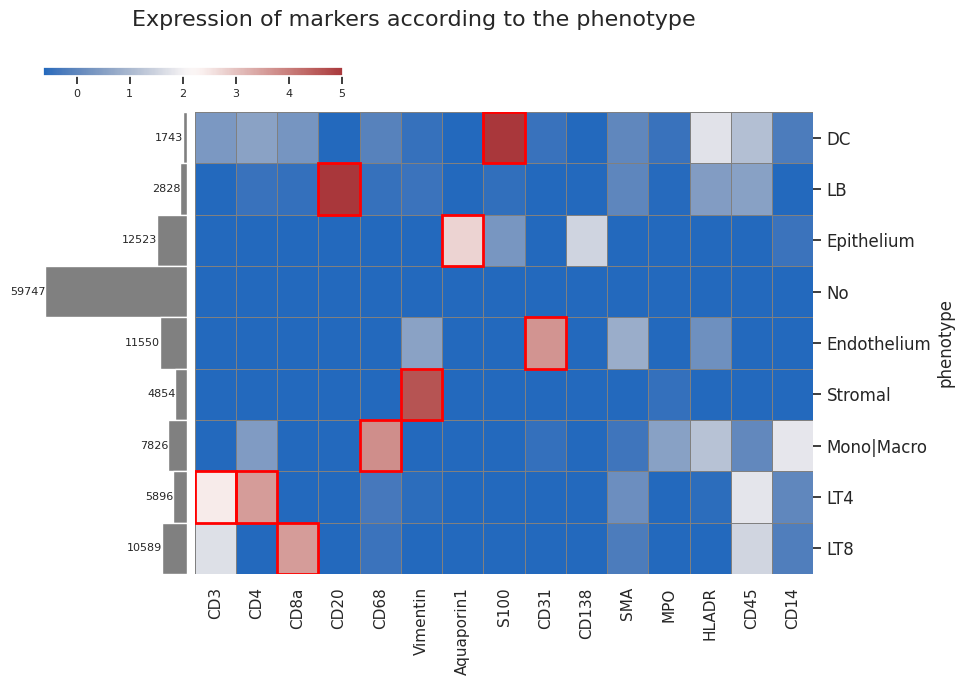

In [200]:
df_pheno = pd.read_csv(path_main_clust + "mfi_pheno.csv")
df_pheno = df_pheno.drop(["Cell_ID", "area", "centroid-0", "centroid-1", "ROI", "coord","Unnamed: 0","cluster"], axis=1)

heatmap_histo(df_pheno,"phenotype","Expression of markers according to the phenotype",path_main_clust,threshold=1.5,vmin=0,vmax=3)


### Reduction of dimension on the cell with a defined phenotype

#### Functions

In [201]:
%pip install pacmap
import pacmap

In [202]:

def plot_pacmap(df_pacmap,feature, figsize=(8, 6), savepath=None,title=""):
    # Order phenotypes by frequency (optional but nice for legend)
    pheno_counts = df_pacmap[feature].value_counts()
    phenotypes = pheno_counts.index.tolist()

    # Palette with as many distinct colors as phenotypes
    palette = sns.color_palette("tab20", n_colors=len(phenotypes))
    pheno_to_color = {ph: palette[i] for i, ph in enumerate(phenotypes)}

    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Plot phenotype by phenotype (gives more control than seaborn.scatterplot)
    for ph in phenotypes:
        sub = df_pacmap[df_pacmap[feature] == ph]
        ax.scatter(
            sub['0'],
            sub['1'],
            s=8,
            color=pheno_to_color[ph],
            alpha=0.7,
            edgecolor="none",
            label=f"{ph} (n={len(sub)})"
        )

    ax.set_xlabel("PaCMAP 1", fontsize=11)
    ax.set_ylabel("PaCMAP 2", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # Legend outside the plot
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=9,
        markerscale=4.0,
        title=feature
    )

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"✅ The graph can be found there:  {savepath}")

    plt.show()




In [203]:
def display_reduction_marker(reduced_vector,marker,size_picture,path,title,subtitle,min,max):

  plt.figure(figsize=size_picture)
  plt.title(title+subtitle,fontsize=40)
  plt.scatter(reduced_vector[:,0],reduced_vector[:,1],c=marker,s=0.5,label=subtitle,vmin=min,vmax=max)
  plt.axis('off')
  plt.colorbar(label=subtitle)
  plt.legend(fontsize=20)
  plt.savefig(path+title+"_"+subtitle+".png")
  print("✅ The graph can be found there:  "+path+title+"_"+subtitle+".png")
  plt.show()

#### Execution

In [204]:
path_reduction_dimension=path_main_clust+"reduction_dimension/"
if os.path.isdir(path_reduction_dimension)==False:
  os.mkdir(path_reduction_dimension)

In [205]:
if os.path.isdir(path_main_clust+"reduction_dimension/markers/")==False:
  os.mkdir(path_main_clust+"reduction_dimension/markers/")

In [206]:
df_pheno.head()

,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,SMA,MPO,HLADR,CD45,CD14,phenotype
0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,-0.244615,-0.553248,-0.302119,-0.280525,-0.524609,-0.026694,No
1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,0.317548,-0.669646,-0.581157,-0.567980,0.022562,1.635892,No
2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,-0.505190,-0.087198,-0.581157,0.619602,-0.524609,0.270712,No
3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,-0.012317,-0.223701,-0.581157,-0.609863,-0.332533,-0.542375,No
4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,-0.307195,-0.381405,-0.581157,-0.557700,-0.524609,1.345280,No


In [207]:
df_pheno=pd.read_csv(path_main_clust+"mfi_pheno.csv")
df_pheno=df_pheno.drop(["Unnamed: 0","ROI","area","centroid-0","centroid-1","coord","Cell_ID","cluster"],axis=1)

# Dynamically get the list of all marker columns from the cleaned df_pheno
all_marker_columns = df_pheno.columns.drop("phenotype").tolist()

df_umap=df_pheno.copy()
# Use the correct list of all marker columns for dimensionality reduction
df_umap=df_umap[all_marker_columns]
df_umap["phenotype"]=df_pheno["phenotype"]
df_umap=df_umap.loc[df_umap.loc[:,"phenotype"]!="No"]
print(df_umap.shape)
list_pheno=list(df_umap["phenotype"])
df_pacmap=df_umap.drop(["phenotype"],axis=1)

embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
X_transformed = embedding.fit_transform(df_pacmap, init="pca")

df_pacmap=pd.DataFrame(X_transformed,columns=["0","1"])
df_pacmap["phenotype"]=list_pheno
df_pacmap.to_csv(path_clust+"pacmap_reduction_pheno.csv")
print(df_pacmap.shape)
df_pacmap.head()

(57809, 16)
(57809, 3)


,0,1,phenotype
0,-11.036919,5.401029,Stromal
1,-10.610339,6.804718,Stromal
2,-7.261611,-10.843345,Epithelium
3,-10.939785,2.909830,Stromal
4,15.860117,-0.676451,DC


✅ The graph can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/reduction_dimension/pacmap_phenotype.png


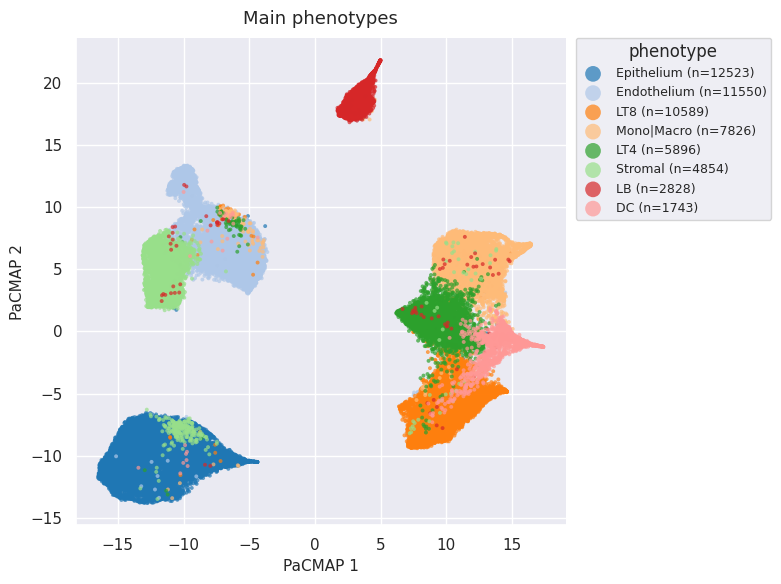

In [208]:
plot_pacmap(df_pacmap, "phenotype",savepath=path_reduction_dimension + "pacmap_phenotype.png",title="Main phenotypes")

In [209]:
df_mfi=df_pheno.copy()
df_mfi=df_mfi[df_mfi["phenotype"]!="No"]
df_mfi=df_mfi.drop(["phenotype"],axis=1)
pacmap_embeded=np.array(df_pacmap)
for marker in df_mfi.columns:
 list_marker=list(df_mfi[marker])
 display_reduction_marker(pacmap_embeded,list_marker,(17,13),path_main_clust+"reduction_dimension/markers/","PacMap_",marker,0,5)

Output hidden; open in https://colab.research.google.com to view.

### Dotplot co expression phenotypes


#### Functions

In [105]:
def plot_density_df(df, marker_x, marker_y, path_out,pheno,
                    palette='tab10',
                    x_thresh=None, y_thresh=None
                    ):

    plt.figure(figsize=(8, 6))
    x = df[marker_x].values
    y = df[marker_y].values

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    sc = plt.scatter(x, y, c=z, cmap='viridis', s=3, edgecolor='none', alpha=0.7)

    sns.kdeplot(x=x, y=y, levels=5, linewidths=1, color='black', alpha=0.6)

    if x_thresh is not None:
        plt.axvline(x=x_thresh, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    if y_thresh is not None:
        plt.axhline(y=y_thresh, color='red', linestyle='--', linewidth=1.5, alpha=0.8)

    if x_thresh is not None and y_thresh is not None:
        x_pos = x > x_thresh
        y_pos = y > y_thresh

        n_total = len(x)
        n_xpos = np.sum(x_pos)
        n_ypos = np.sum(y_pos)
        n_double_pos = np.sum(x_pos & y_pos)
        n_double_neg = np.sum(~x_pos & ~y_pos)

        p_xpos = 100 * n_xpos / n_total
        p_ypos = 100 * n_ypos / n_total
        p_double_pos = 100 * n_double_pos / n_total
        p_double_neg = 100 * n_double_neg / n_total

        txt = (
            f"Total cells: {n_total}\n"
            f"{marker_x}+ : {n_xpos} ({p_xpos:.1f}%)\n"
            f"{marker_y}+ : {n_ypos} ({p_ypos:.1f}%)\n"
            f"Double + : {n_double_pos} ({p_double_pos:.1f}%)\n"
            f"Double - : {n_double_neg} ({p_double_neg:.1f}%)"
        )

        plt.text(0.98, 0.98, txt, transform=plt.gca().transAxes,
                 fontsize=9, color='white', fontweight='bold',
                 ha='right', va='top',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.4'))

    plt.xlabel(marker_x)
    plt.ylabel(marker_y)
    plt.title(f"{marker_x} vs {marker_y} in {pheno}")
    plt.colorbar(sc, label='Density')

    plt.tight_layout()
    plt.savefig(path_out + f"/{marker_x}_{marker_y}.png", dpi=300)
    print(f"✅ The graph can be found there:  {path_out}")
    plt.show()


#### Execution

In [106]:

df_pheno=pd.read_csv(path_main_clust+"/mfi_pheno.csv")
df_pheno=df_pheno.drop(["Cell_ID","area","centroid-0","centroid-1","ROI","coord","Unnamed: 0","cluster"],axis=1)
print(df_pacmap.shape)
df_pheno.head()

(41422, 3)


,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,CD138,SMA,MPO,HLADR,CD45,CD14,phenotype
0,0.202029,1.410180,-0.412477,-0.306525,-0.164025,-0.299243,0.329767,0.077405,-0.486542,0.024561,-0.375191,-0.336353,-0.178144,-0.471418,0.243803,No
1,-0.807486,-1.386250,-0.412477,-0.306525,-1.047819,-0.469368,-1.320833,-1.240788,-0.804661,-1.646065,-0.873363,-0.891435,-0.610240,-0.471418,-1.415693,No
2,-0.807486,-1.386250,-0.412477,-0.306525,-1.047819,-0.469368,-1.320833,-1.240788,-0.804661,-1.646065,-0.873363,-0.891435,-0.610240,-0.471418,-1.415693,No
3,-0.807486,-1.386250,-0.412477,-0.306525,-1.047819,-0.469368,-1.320833,-1.240788,-0.804661,-1.646065,-0.873363,-0.891435,-0.610240,-0.471418,-1.415693,No
4,0.827292,-0.166088,-0.115783,-0.306525,-0.106039,-0.319172,-0.003159,-0.118341,-0.804661,-0.030571,-0.188639,-0.891435,-0.477147,-0.471418,1.541456,No


In [107]:
path_coexpression_pheno=path_main_clust+"coexpression_phenotypes/"
if os.path.isdir(path_coexpression_pheno)==False:
  os.mkdir(path_coexpression_pheno)

##### Choose the markers

In [108]:
dico_pheno_marker={}
for p in np.unique(df_pheno["phenotype"]):
  list_marker=input("Enter the markers you want to display for the phenotype "+p+": ")
  list_marker=list_marker.split(",")
  dico_pheno_marker[p]=list_marker

KeyboardInterrupt: Interrupted by user

In [ ]:
threshold=float(input("Enter the threshold for the density plot: "))


In [ ]:
for pheno in dico_pheno_marker.keys():
  print(pheno)
  df_sub=df_pheno[df_pheno["phenotype"]==pheno]
  if os.path.isdir(path_coexpression_pheno+str(pheno))==False:
    os.mkdir(path_coexpression_pheno+str(pheno))
  for m in range(len(dico_pheno_marker[pheno])):
    marker=list(dico_pheno_marker[pheno])[m]
    if marker!="phenotype":
      for m2 in range(m+1,len(dico_pheno_marker[pheno])):
        marker2=list(dico_pheno_marker[pheno])[m2]
        if marker2!="phenotype" and marker2!=marker:
          plot_density_df(df_sub,marker,marker2,path_coexpression_pheno+str(pheno),pheno,x_thresh=threshold,y_thresh=threshold)

##### Co-expression of all the markers

In [110]:
threshold=float(input("Enter the threshold for the density plot: "))

Enter the threshold for the density plot: 1


Endothelium


KeyboardInterrupt: 

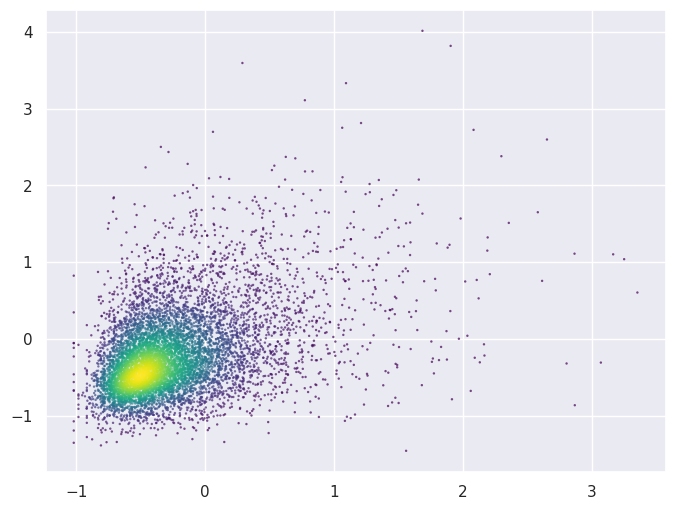

In [112]:
for pheno in np.unique(df_pheno["phenotype"]):
 if pheno!="No":
  print(pheno)
  df_pheno=df_pheno[df_pheno["phenotype"]==pheno]
  if os.path.isdir(path_coexpression_pheno+str(pheno))==False:
    os.mkdir(path_coexpression_pheno+str(pheno))
  for m in range(len(list(df_pheno.columns))):
    marker=list(df_pheno.columns)[m]
    if marker!="phenotype":
      for m2 in range(m+1,len(list(df_pheno.columns))):
        marker2=list(df_pheno.columns)[m2]
        if marker2!="phenotype" and marker2!=marker:
          plot_density_df(df_pheno,marker,marker2,path_coexpression_pheno+str(pheno),"phenotype",x_thresh=threshold,y_thresh=threshold)

### Representation of the phenotype and the markers belonging to assess the quality of phenotype annotation


#### Functions

In [210]:
def outline(image, mask, color=(0, 255, 0), thickness=1):
    """
    Draws the contours of objects defined in a numeric (non-binary) mask.

    Args:
        mask (np.ndarray): 2D mask with integer values
                           (e.g., 0 = background, 1, 2, ... = objects).
        image (np.ndarray): Image on which to draw the contours.
                            If None, a black image is created.
        color (tuple): Contour color (in BGR format).
        thickness (int): Contour line thickness.

    Returns:
        np.ndarray: Image with drawn contours.
    """

    if image is None:
        image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    mask = mask.astype(np.int32)
    objects = np.unique(mask)
    objects = objects[objects != 0]  # Ignore background

    for value in objects:
        # Create a binary mask for the current object
        binary_mask = (mask == value).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw contours
        cv2.drawContours(image, contours, -1, color, thickness)

    return image


In [211]:
import warnings
from tqdm.auto import tqdm


# --- disable matplotlib user warnings (ex: layout, clipping, etc.) ---
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


def load_image(path):
    try:
        return plt.imread(path)
    except FileNotFoundError:
        print(f"Image not found: {path}")
        return None


def build_mask(df_pheno, roi, pheno, shape):
    mask = np.zeros(shape)
    matches = df_pheno[(df_pheno["ROI"] == roi) & (df_pheno["phenotype"] == pheno)]
    cell_id = 1
    for _, row in matches.iterrows():
        for pixel in row["coord"].split(";")[:-1]:
            x, y = map(int, pixel.split(","))
            mask[x, y] = cell_id
        cell_id += 1
    return mask


def build_mask_color(df_pheno, roi, pheno, shape):
    mask = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
    matches = df_pheno[(df_pheno["ROI"] == roi) & (df_pheno["phenotype"] == pheno)]
    for _, row in matches.iterrows():
        color = np.random.randint(50, 256, size=3)  # random bright color
        for pixel in row["coord"].split(";")[:-1]:
            x, y = map(int, pixel.split(","))
            mask[x, y] = color
    return mask


def generate_phenotype_image(file, pheno, path_img, path_check, df_pheno, dico_pheno_marker):
    markers = dico_pheno_marker[pheno]
    img_tot = None
    img_shape = None

    # --- load & sum marker images ---
    for marker in markers:
        marker_path = os.path.join(path_img, file, marker + ".png")
        img = load_image(marker_path)
        if img is None:
            continue

        if img_tot is None:
            img_tot = img.copy()
            img_shape = img.shape
        else:
            img_tot += img

    if img_tot is None:
        # nothing loaded for this ROI / phenotype
        return

    img_mask = build_mask(df_pheno, file, pheno, img_shape)
    img_mask_color = build_mask_color(df_pheno, file, pheno, img_shape)

    # layout
    rows, cols = (1, 3) if img_shape[0] * 3 > img_shape[1] else (3, 1)

    fig = plt.figure(figsize=(20, 10))
    plt.subplots_adjust(wspace=0.01, hspace=0.3)

    # 1) summed markers
    plt.subplot(rows, cols, 1)
    plt.imshow(np.arcsinh(img_tot * 10), cmap="gray")
    plt.axis("off")
    plt.title(" + ".join(markers))

    # 2) colored mask (one color per cell)
    plt.subplot(rows, cols, 2)
    plt.imshow(img_mask_color)
    plt.axis("off")
    plt.title(pheno)

    # 3) outline overlay (outline() is assumed to be defined elsewhere)
    plt.subplot(rows, cols, 3)
    plt.imshow(outline(np.arcsinh(img_tot * 10), img_mask, [0, 255, 0], 1))
    plt.axis("off")
    plt.title(str(markers))

    # save
    save_dir = os.path.join(path_check, pheno)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{file}.png")

    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


def process_all(path_img, path_check, df_pheno, dico_pheno_marker):
    files = sorted(os.listdir(path_img))

    # progress over ROIs
    for file in tqdm(files, desc="ROIs", unit="ROI"):
        # progress over phenotypes for this ROI
        for pheno in tqdm(dico_pheno_marker.keys(),
                          desc=f"Phenotypes for {file}",
                          unit="pheno",
                          leave=False):
            output_path = os.path.join(path_check, pheno, f"{file}.png")
            if not os.path.isfile(output_path):
                generate_phenotype_image(
                    file=file,
                    pheno=pheno,
                    path_img=path_img,
                    path_check=path_check,
                    df_pheno=df_pheno,
                    dico_pheno_marker=dico_pheno_marker,
                )
    print(f"✅ The files can be found in the following folder:  {path_check}")

#### Execution

In [212]:
processing=input("Enter 1 or 2 to choose the image processing used to display the clusters: ")

Enter 1 or 2 to choose the image processing used to display the clusters: 2


In [222]:
path_check=path_main_clust+"check_pheno/"
path_img=path+"images/img_processing_"+processing+"/Biopsies/"
if os.path.isdir(path_check)==False:
  os.mkdir(path_check)

In [214]:
df_pheno = pd.read_csv(path_main_clust + "mfi_pheno.csv")
df_pheno.head()

,Unnamed: 0,CD3,CD4,CD8a,CD20,CD68,Vimentin,Aquaporin1,S100,CD31,...,CD45,CD14,Cell_ID,area,centroid-0,centroid-1,ROI,coord,cluster,phenotype
0,0,0.052958,1.127435,-0.452091,-0.334868,-0.306653,-0.364981,0.074943,-0.125290,-0.610470,...,-0.524609,-0.026694,0,28.0,3.928571,1.250000,19U08731 a,"0,0;0,1;1,0;1,1;1,2;2,0;2,1;2,2;3,0;3,1;3,2;3,...",3,No
1,1,-0.555585,0.904230,-0.452091,0.007533,-0.744610,-0.314097,-0.820821,-0.086372,-0.456492,...,0.022562,1.635892,1,52.0,2.653846,15.788462,19U08731 a,"0,13;0,14;0,15;0,16;0,17;0,18;0,19;1,12;1,13;1...",4,No
2,2,-0.335527,0.344865,-0.058703,-0.334868,0.584927,0.068253,-1.159082,1.203576,-0.811049,...,-0.524609,0.270712,2,21.0,1.000000,39.000000,19U08731 a,"0,36;0,37;0,38;0,39;0,40;0,41;0,42;1,36;1,37;1...",4,No
3,3,-0.847605,-0.344715,-0.070673,0.424733,-0.028019,-0.330437,1.032892,0.876821,-0.904052,...,-0.332533,-0.542375,3,53.0,2.396226,87.433962,19U08731 a,"0,84;0,85;0,86;0,87;0,88;0,89;0,90;0,91;1,83;1...",3,No
4,4,0.610739,-0.392510,-0.172469,-0.334868,-0.252108,-0.382188,-0.251405,-0.329976,-0.904052,...,-0.524609,1.345280,4,22.0,1.272727,95.045455,19U08731 a,"0,92;0,93;0,94;0,95;0,96;0,97;0,98;1,93;1,94;1...",5,No


In [219]:
dico_pheno_marker={}
for p in np.unique(df_pheno["phenotype"]):
 if p!="No":
  list_marker=input("Enter the markers present in "+p+"(separated by a comma): ").split(",")
  dico_pheno_marker[p]=list_marker

Enter the markers present in DC(separated by a comma): S100
Enter the markers present in Endothelium(separated by a comma): CD31
Enter the markers present in Epithelium(separated by a comma): CD138,Aquaporin1
Enter the markers present in LB(separated by a comma): CD20
Enter the markers present in LT4(separated by a comma): CD4
Enter the markers present in LT8(separated by a comma): CD8a
Enter the markers present in Mono|Macro(separated by a comma): CD68
Enter the markers present in Stromal(separated by a comma): Vimentin


In [223]:

for pheno in dico_pheno_marker:
    if os.path.isdir(os.path.join(path_check, pheno)) == False:
        os.mkdir(os.path.join(path_check, pheno))

# Appelle la fonction principale ici :
process_all(path_img, path_check, df_pheno,dico_pheno_marker)


ROIs:   0%|          | 0/23 [00:00<?, ?ROI/s]

Phenotypes for 19U08731 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 d:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 e:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 f:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 g:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 d:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 e:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 f:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 g:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U02147 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U05395 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U05395 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

✅ The files can be found in the following folder:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/main_clustering/check_pheno/
